In [ ]:
# Bibliotecas
import torch
from torch import nn
import numpy as np
from os import urandom
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand
from IPython.display import HTML
HTML('''''')
import matplotlib.pyplot as plt


In [ ]:
# Neurônio
class Perceptron(object):

    def __init__(self, no_of_inputs):
        self.weights = np.zeros(no_of_inputs + 1)

    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        if summation > 0:
          activation = summation
        else:
          activation = 0
        return activation

In [ ]:
class LineNetwork(nn.Module):
  # Inicialização
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, 1)
    )

  # Como a rede computa
  def forward(self, x):
    return self.layers(x)

In [ ]:
# contruindo um DataSet

In [ ]:
class AlgebraicDataset(Dataset):
  def __init__(self, f, interval, nsamples):
    X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
    self.data = [(x, f(x)) for x in X]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
line = lambda x: 2*x + 3
interval = (-10, 10)
train_nsamples = 1000
test_nsamples = 100

In [ ]:
train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True)

In [ ]:
# 3.2 Hiperparâmentros e otimização

In [ ]:
# derificar device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [ ]:
# model / Modelo
model = LineNetwork().to(device)

In [ ]:
# Função de perda (loss function)
# Erro quadrático médio (Mean Squared Error)
lossfunc = nn.MSELoss()
# Gradiente Descendente Estocástico
# SGD = Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# taxa de aprendizado lr = learning rate

In [ ]:
# função de treino
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0
  for X, y in dataloader:
    X = X.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    pred = model(X)
    loss = lossfunc(pred, y)

    # zera os gradientes acumulados
    optimizer.zero_grad()
    # computa os gradientes
    loss.backward()
    # anda, de fato, na direção que reduz o erro local
    optimizer.step()

    # loss é um tensor; item pra obter o float
    cumloss += loss.item()

  return cumloss / len(dataloader)


def test(model, dataloader, lossfunc):
  model.eval()

  cumloss = 0.0
  with torch.no_grad():
    for X, y in dataloader:
      X = X.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(X)
      loss = lossfunc(pred, y)
      cumloss += loss.item()

  return cumloss / len(dataloader)

In [ ]:
# treinando a rede

In [ ]:
# Pra visualizar
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), label="model")
  plt.legend()
  plt.show()

Epoch: 0; Train Loss: 32.937015533447266


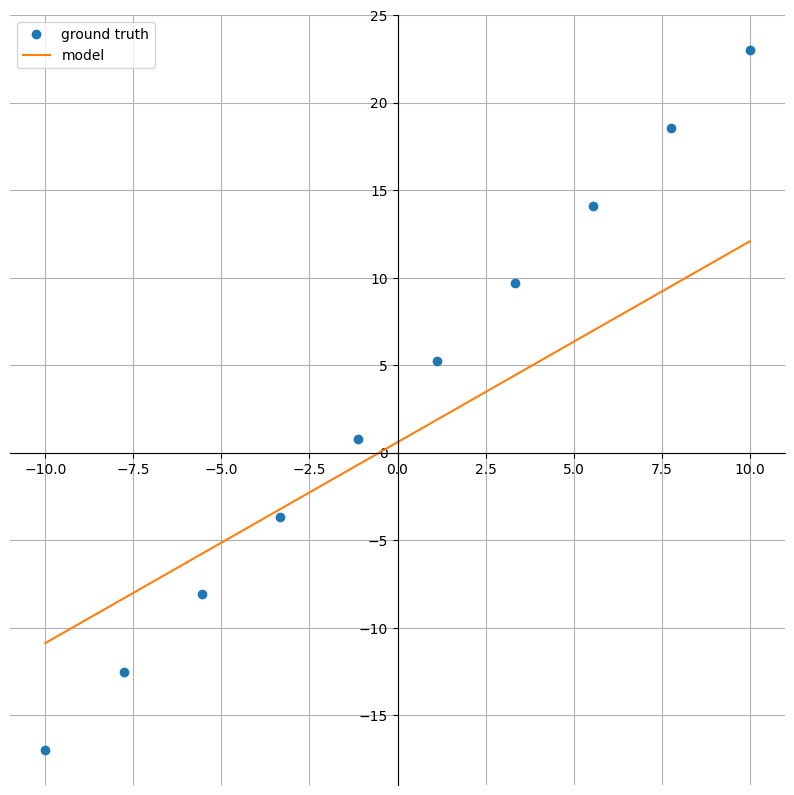

Epoch: 10; Train Loss: 12.776549339294434


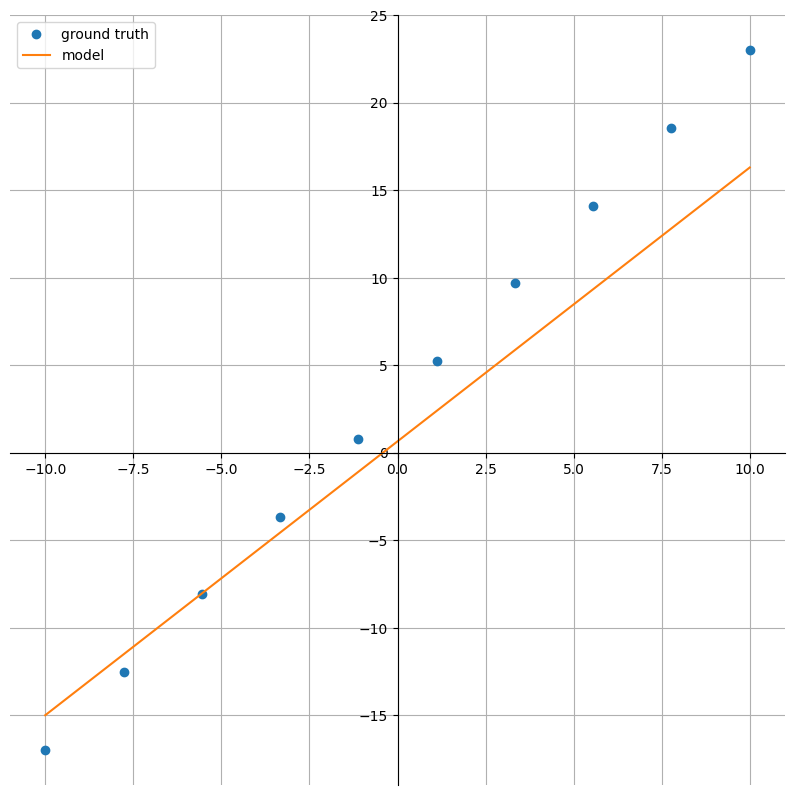

Epoch: 20; Train Loss: 7.279937267303467


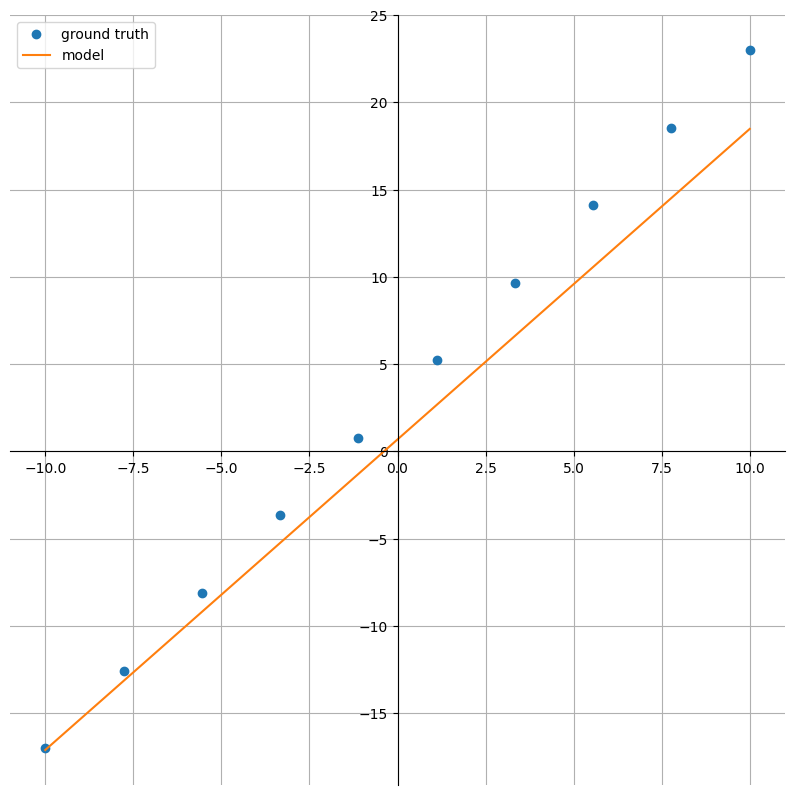

Epoch: 30; Train Loss: 5.671794891357422


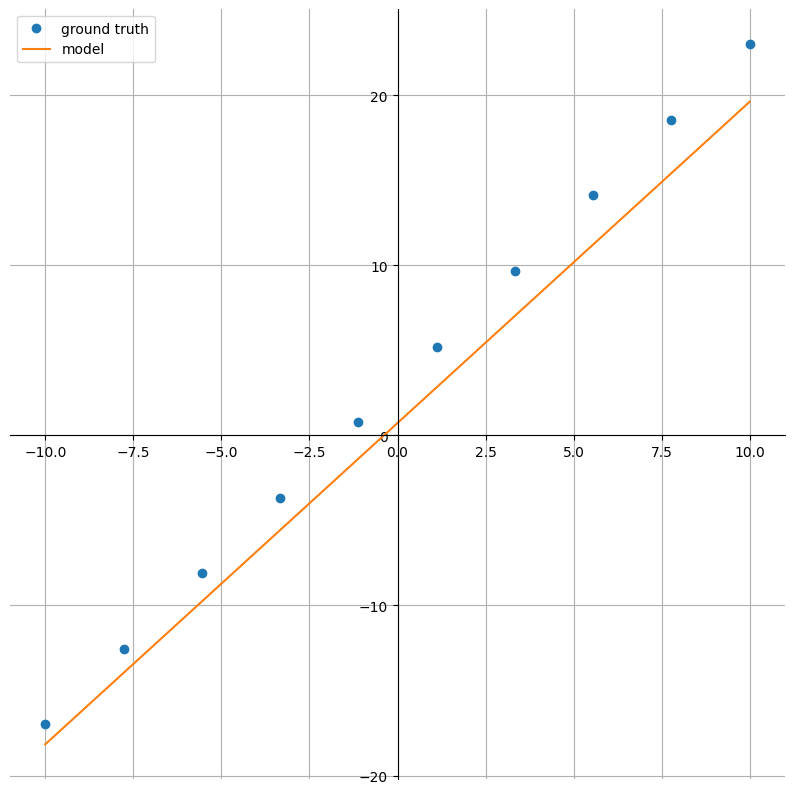

Epoch: 40; Train Loss: 5.099119186401367


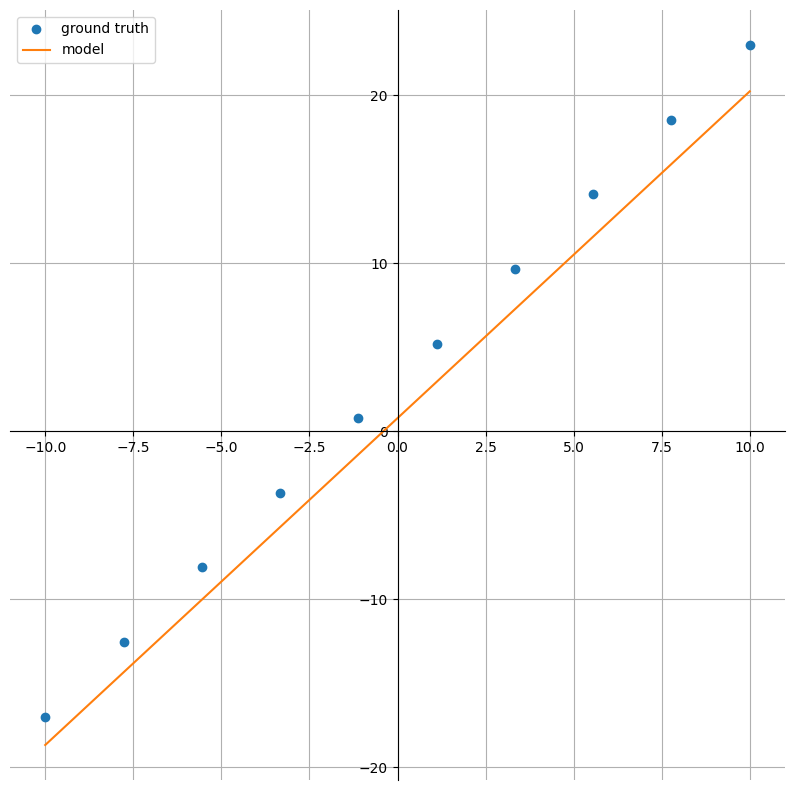

Epoch: 50; Train Loss: 4.8063435554504395


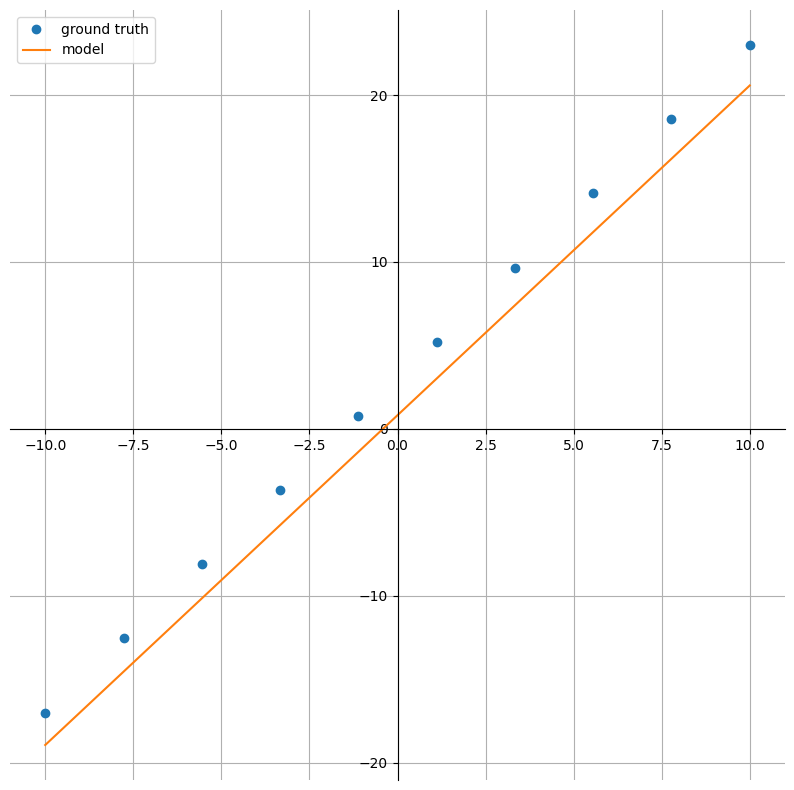

Epoch: 60; Train Loss: 4.593212127685547


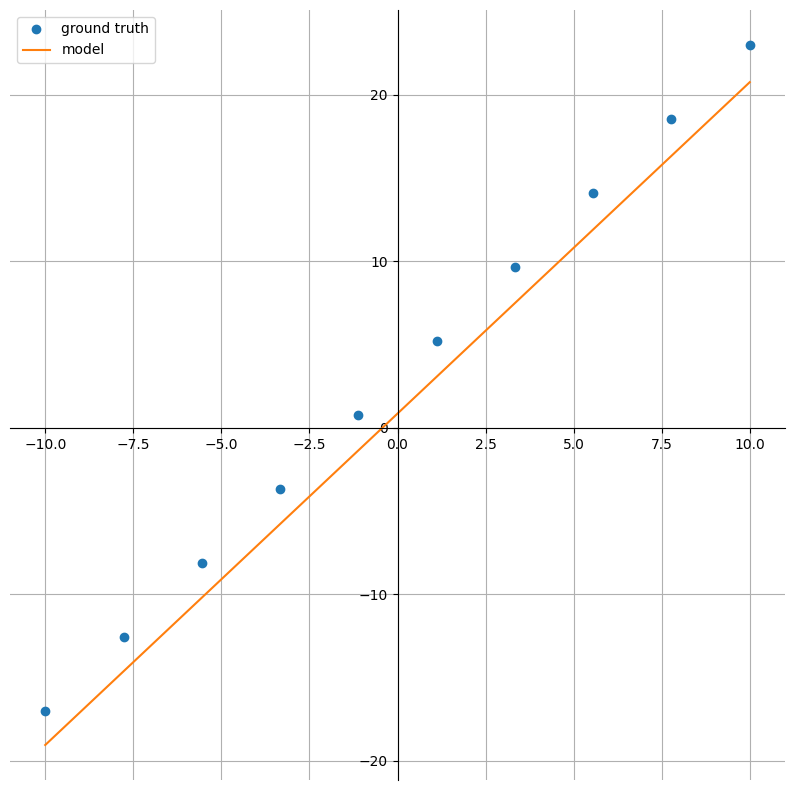

Epoch: 70; Train Loss: 4.406486511230469


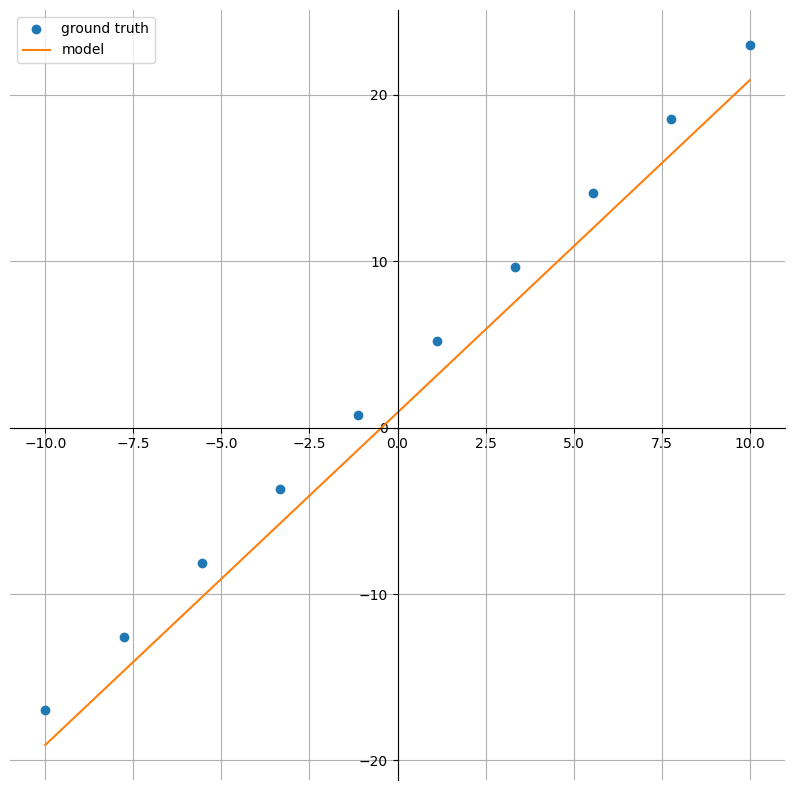

Epoch: 80; Train Loss: 4.231863975524902


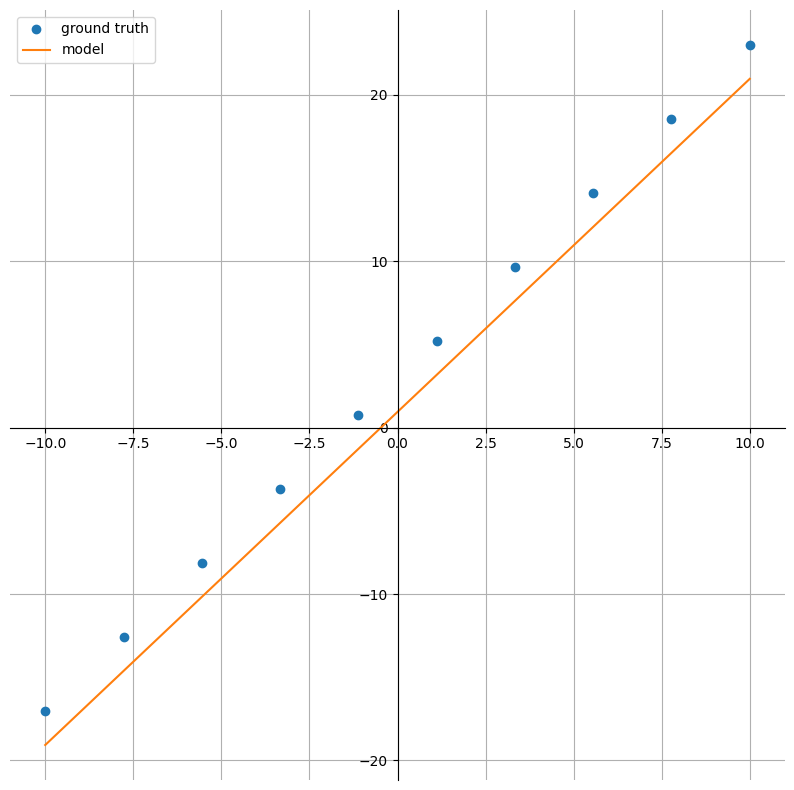

Epoch: 90; Train Loss: 4.0653581619262695


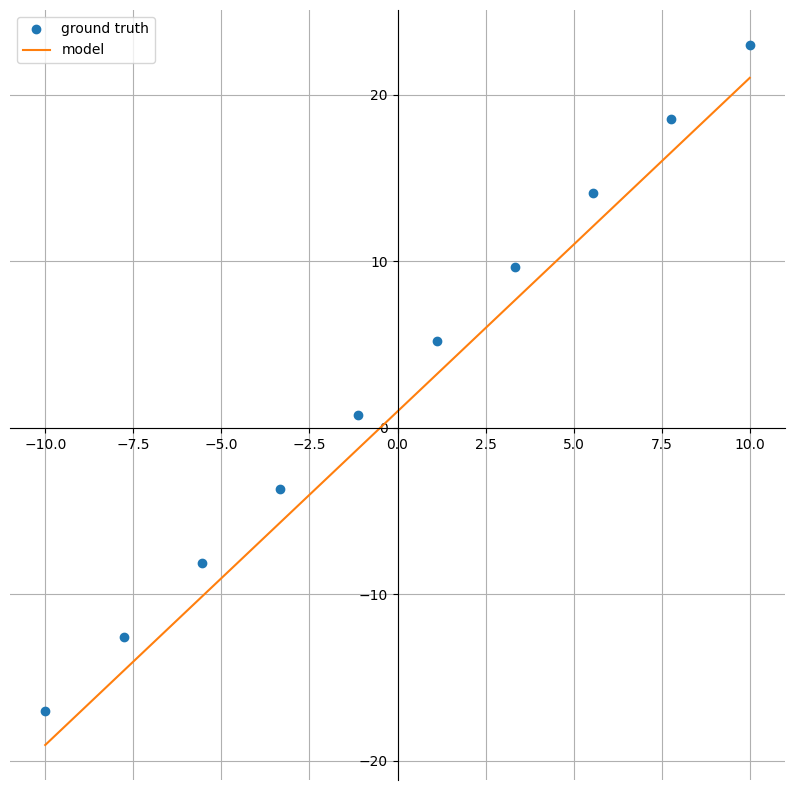

Epoch: 100; Train Loss: 3.9057207107543945


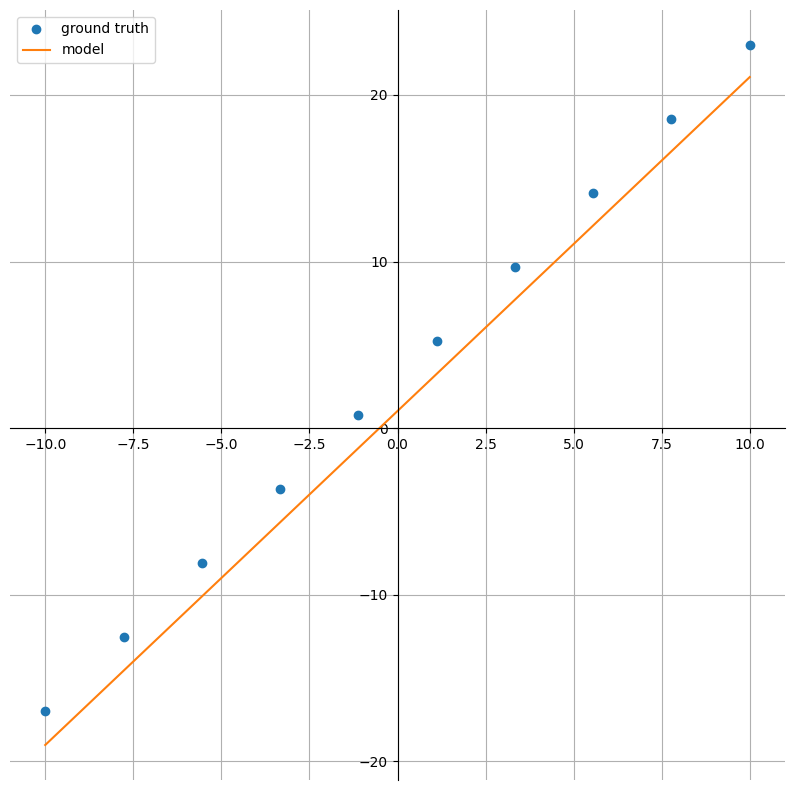

Epoch: 110; Train Loss: 3.7524352073669434


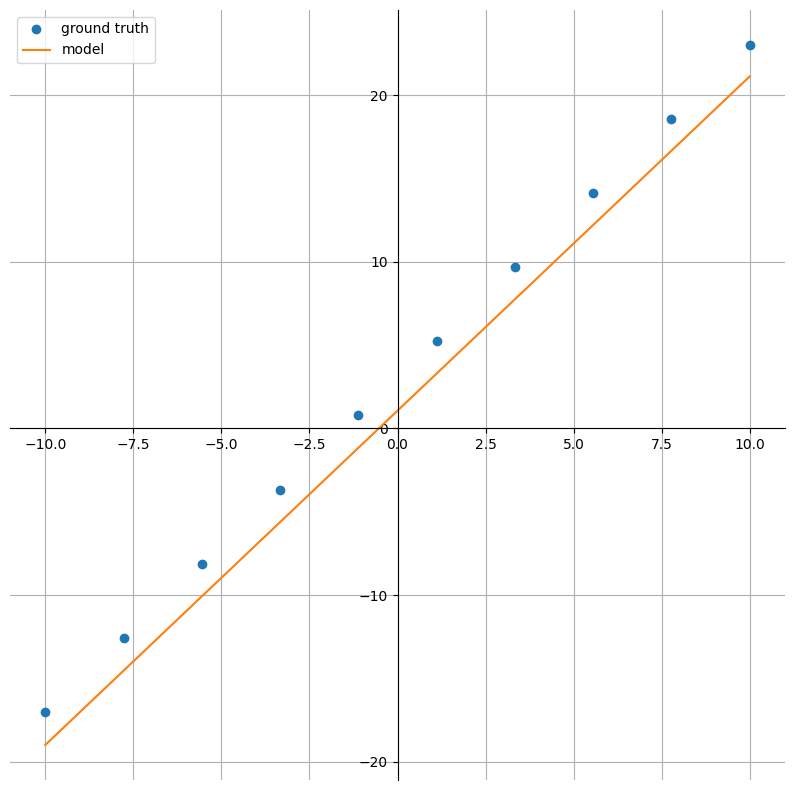

Epoch: 120; Train Loss: 3.6051888465881348


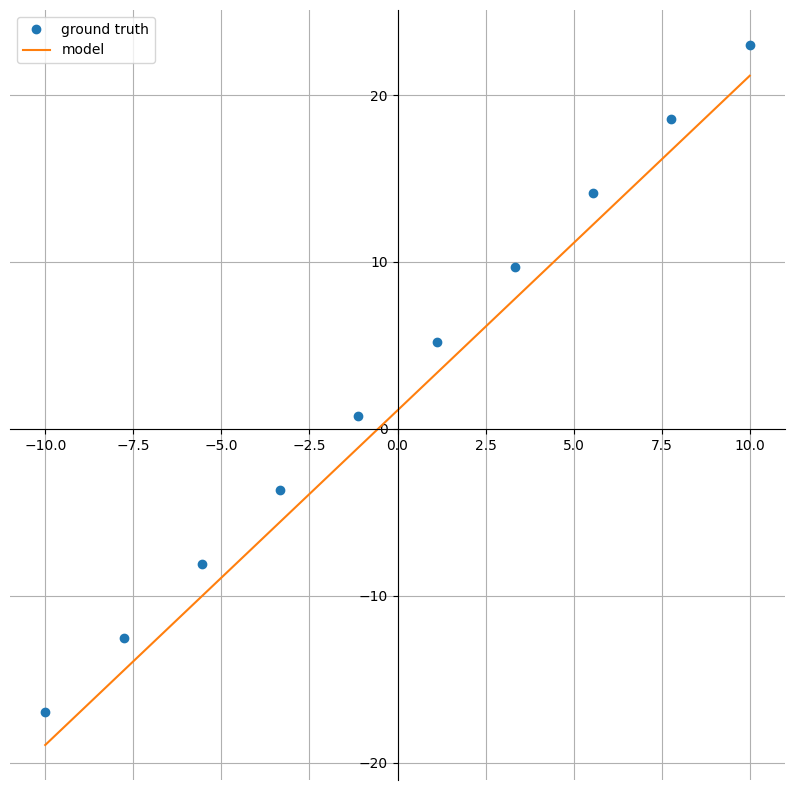

Epoch: 130; Train Loss: 3.4637253284454346


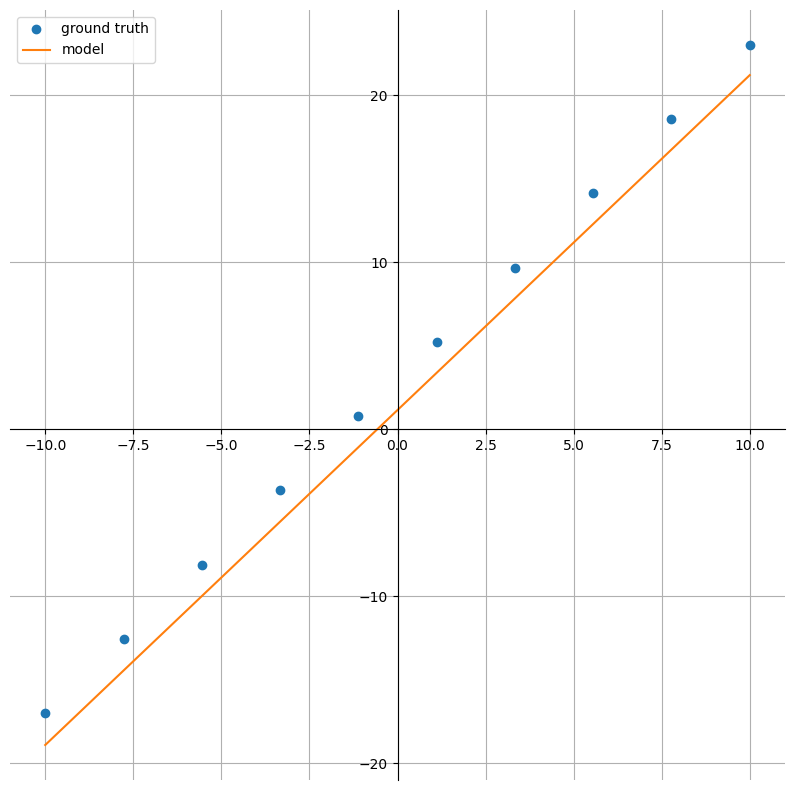

Epoch: 140; Train Loss: 3.3278160095214844


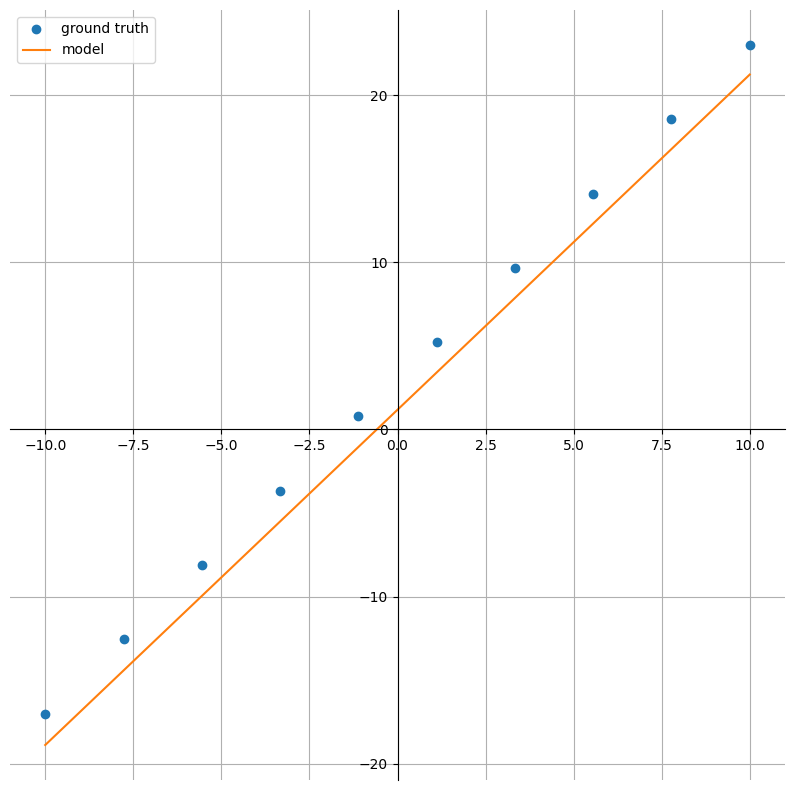

Epoch: 150; Train Loss: 3.197239398956299


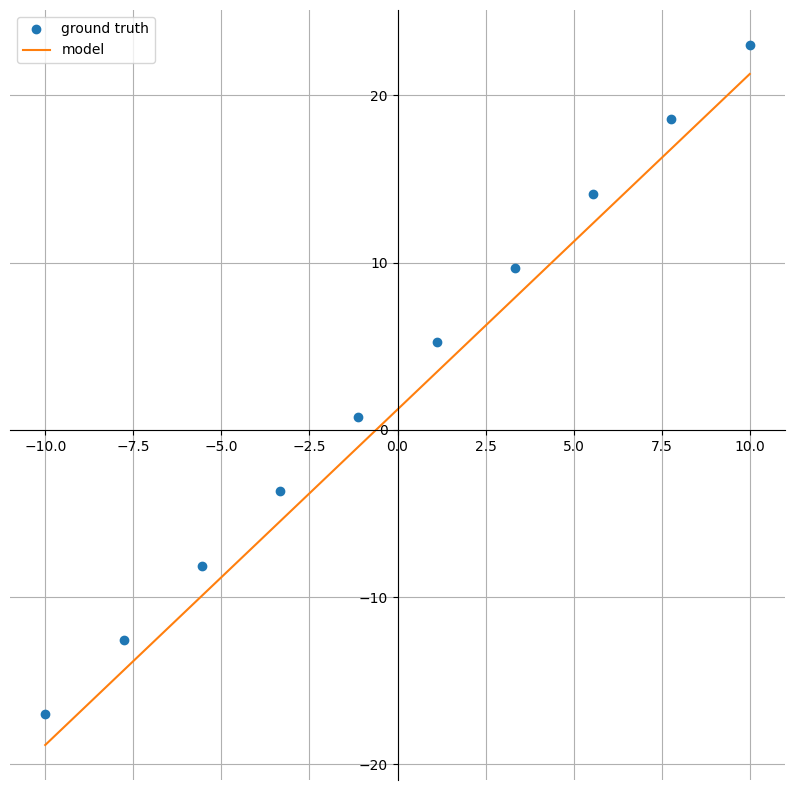

Epoch: 160; Train Loss: 3.0717856884002686


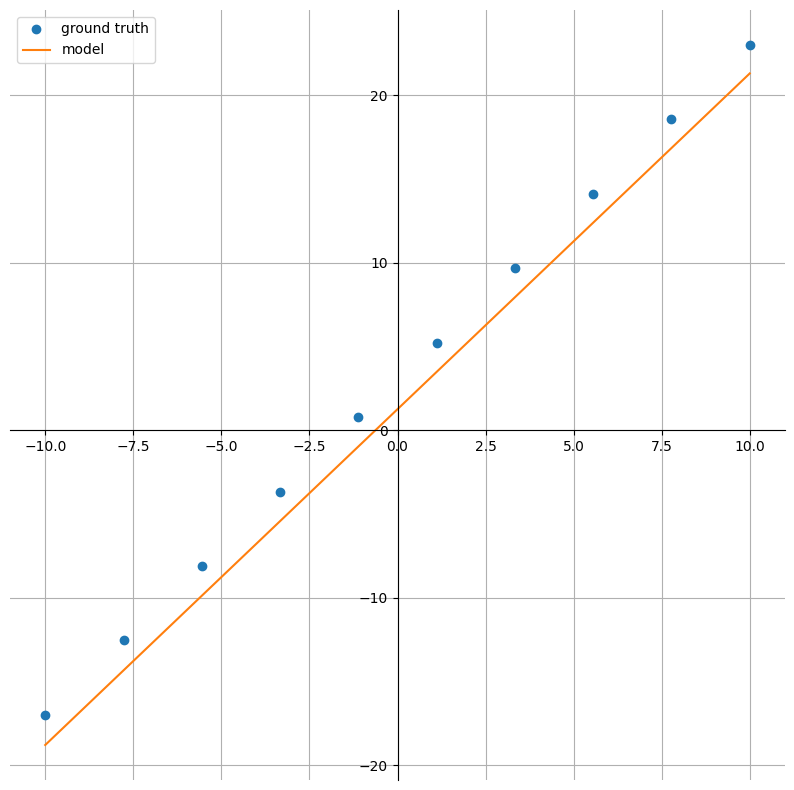

Epoch: 170; Train Loss: 2.951253890991211


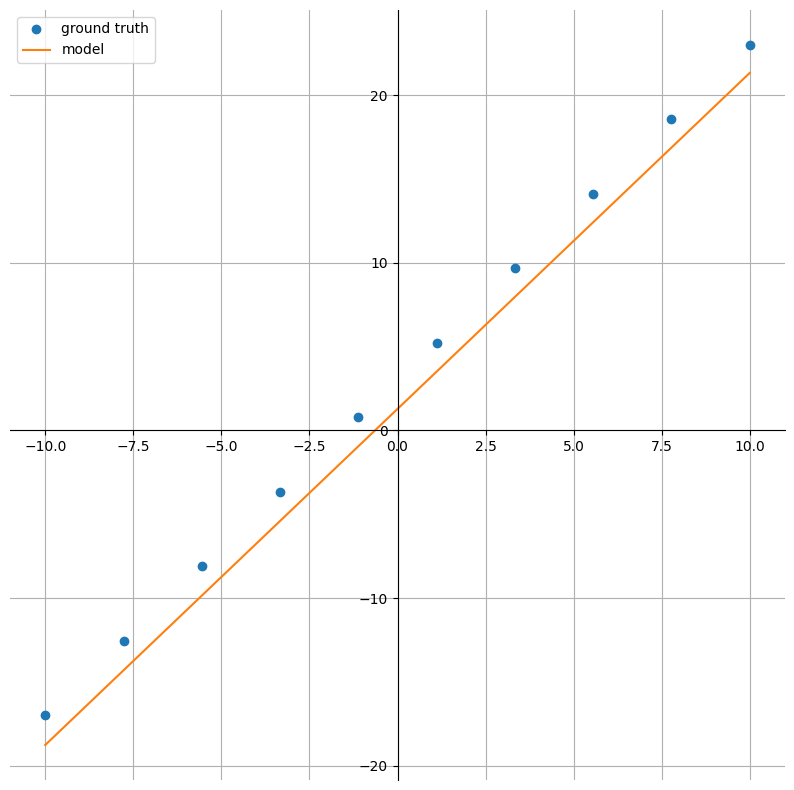

Epoch: 180; Train Loss: 2.8354523181915283


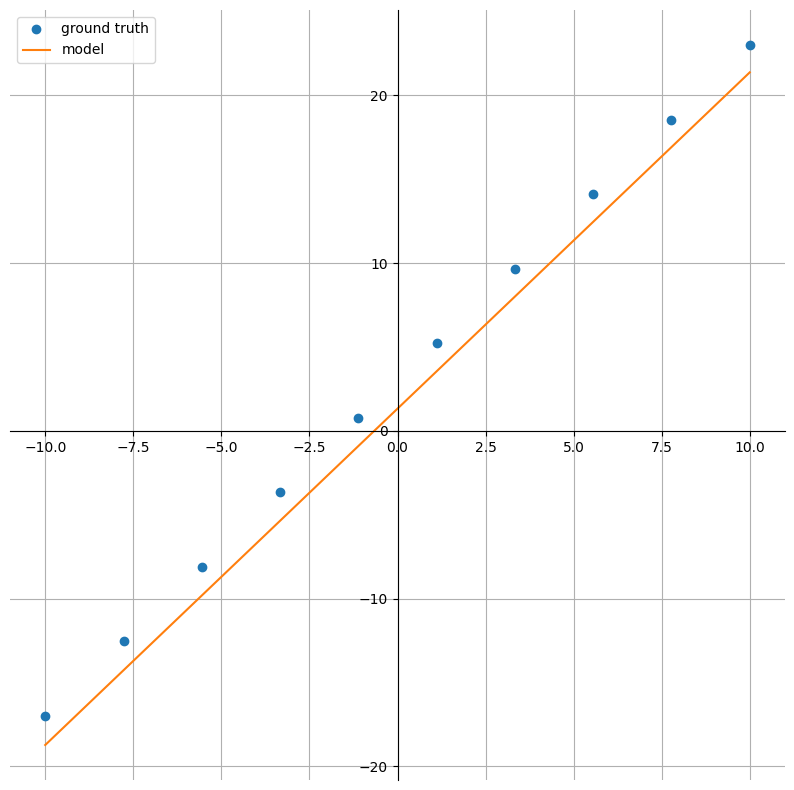

Epoch: 190; Train Loss: 2.7241947650909424


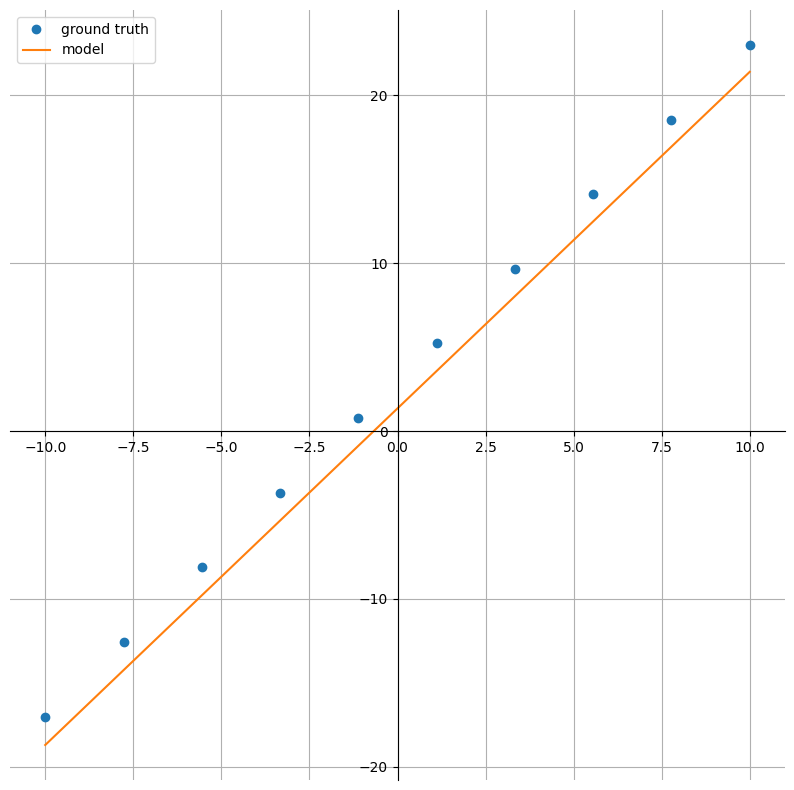

Epoch: 200; Train Loss: 2.6173033714294434


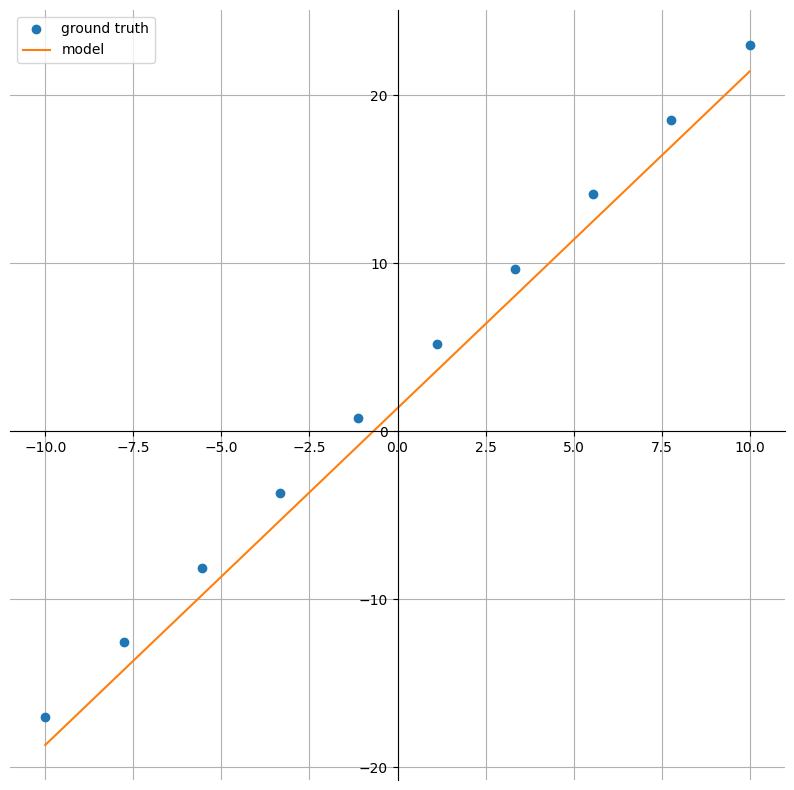

Test Loss: 2.6128041744232178


In [ ]:
epochs = 201
for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    plot_comparinson(line, model)

test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")